# Homework 8. - SciServer
## Balázs Menkó (O67UT7)
---
These assignments aims to serve as a practical introduction to the SciServer infrastructure and its basic operation, with an exclusive focus on astronomy databases.

There will be tasks that you'll need to solve on the SciServer and tasks that you'll need to solve in Python. It will be specified for each of them. Always use the latest data release of SDSS (DR18 currently).

In [1]:
# packages
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from SciServer import CasJobs

context = 'DR18'

---
# Task 1 - SOLVE ON THE SCISERVER.
- Write an SQL query to retrieve a list of 1000 galaxies within a specified range of redshift values. Join the SpecObj and Galaxy views on the specObjID column and retrieve the ID, the redshift and the Petrosian U, G, R, I, Z magnitudes from the database, along with their corresponding errors. The redshift range should be 0.1 < z < 0.7.
- In CasJobs's "MyDB" menu, select your newly acquired data set and using SciServer's built-on "Plot" method, plot the redshifts as the function of one of the color magnitudes.
- Upload the plot here! If it looks terrible, then good job! It should. Welcome to SciServer's plot functionality.

In [2]:
df1 = CasJobs.executeQuery(sql='''
    SELECT TOP 1000
        s.specObjID,
        s.z,
        g.petroMag_u AS Petrosian_U,
        g.petroMagErr_u AS Petrosian_U_Error,
        g.petroMag_g AS Petrosian_G,
        g.petroMagErr_g AS Petrosian_G_Error,
        g.petroMag_r AS Petrosian_R,
        g.petroMagErr_r AS Petrosian_R_Error,
        g.petroMag_i AS Petrosian_I,
        g.petroMagErr_i AS Petrosian_I_Error,
        g.petroMag_z AS Petrosian_Z,
        g.petroMagErr_z AS Petrosian_Z_Error
    --INTO -- needed only once
      --  MyDB
    FROM Galaxy g
    JOIN
        SpecObj s ON s.specObjID = g.specObjID
    WHERE
        g.clean=1
        AND s.z BETWEEN 0.1 AND 0.7
''', context=context, format='pandas')
df1.head()

,specObjID,z,Petrosian_U,Petrosian_U_Error,Petrosian_G,Petrosian_G_Error,Petrosian_R,Petrosian_R_Error,Petrosian_I,Petrosian_I_Error,Petrosian_Z,Petrosian_Z_Error
0,3244891160862287872,0.390180,26.13397,2.546697,20.62688,0.123726,18.61670,0.032733,17.91093,0.029389,17.54589,0.074108
1,570851908089047040,0.323714,21.79632,0.679018,20.27013,0.075895,18.55832,0.025424,18.02636,0.024481,17.75954,0.080693
2,570998967769262080,0.260545,20.22713,0.183865,19.74677,0.050139,18.87206,0.035945,18.43069,0.039688,18.06709,0.108748
3,651897734554478592,0.405631,23.99024,3.721098,21.66186,0.234174,20.11797,0.092823,19.37312,0.092258,18.89541,0.197431
4,570845585897187328,0.174030,19.84205,0.118376,18.37600,0.017619,17.36030,0.011789,16.89404,0.012130,16.56335,0.032509


Created figure of the `redshifts` as the function of `Petrosian G` magnitudes using SciServer's built-on "Plot" method. 

<img src="z_vs_Petrosian_G.png" alt="z_vs_Petrosian_G.png" width="500" />



---
# Task 2 - SOLVE IN PYTHON.
- Download the Petrosian magnitudes of 10000 galaxies in the redshift range 0.01 < z < 0.06, using the SciServer's Python API. Remove outliers and use only galaxies, where `g-r` (subtract `r` magnitudes from `g`) is between -0.1 and 1.1!
- Create the 2D density plot of objects in the space of `g` on the x-axis and `g-r` on the y-axis.
- Upload the final plot here!
- Can you notice any correlation/separation/structure in the data? If yes, then please describe! Compare with [this Wikipedia article](https://en.wikipedia.org/wiki/Galaxy_color%E2%80%93magnitude_diagram).

In [3]:
%%time
df2 = CasJobs.executeQuery(sql='''
    SELECT TOP 30000 -- instead of 10k due to a better plot
        s.specObjID,
        g.petroMag_g AS g,
        g.petroMag_g - g.petroMag_r AS g_r_diff
    FROM Galaxy g
    JOIN
        SpecObj s ON s.specObjID = g.specObjID
    WHERE
        g.clean=1
        AND s.z BETWEEN 0.01 AND 0.06
        AND g.petroMag_g - g.petroMag_r BETWEEN -0.1 AND 1.1
''', context=context, format='pandas')

CPU times: user 133 ms, sys: 48.7 ms, total: 182 ms
Wall time: 1.42 s


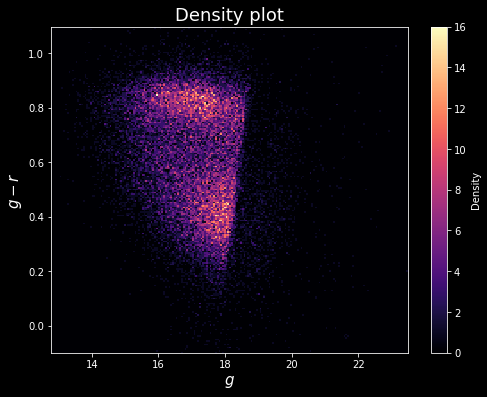

In [4]:
plt.figure(figsize=(8,6))
hist = plt.hist2d(df2.g, df2.g_r_diff, bins=200, cmap='magma')
plt.colorbar(hist[3], label='Density')
plt.title('Density plot', fontsize=18)
plt.xlabel(r'$g$', fontsize=15)
plt.ylabel(r'$g-r$', fontsize=15)
plt.show()

The two main cluster (`red sequence` and `blue cloud`) also visible on the above plot. Between the a lower density also visible which sould be the green valley.


<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Galaxy_color-magnitude_diagram-en.svg" alt="https://upload.wikimedia.org/wikipedia/commons/9/96/Galaxy_color-magnitude_diagram-en.svg" width="500" />


---
# Task 3 - SOLVE IN PYTHON.
- To get slightly familiar with the Schema Browser and basic functions, check the PhotoObj view! Search which parameter stores "flags" and how to access them! (Find the appropriate function in the Schema Browser, the correct syntax will be also there.)
- Individual photographs (called "fields") containing several astronomical objects are defined by three parameters in SDSS: "run", "camcol" and "field". In the field 752-5-517 (run-camcol-field), check what percentage of observed objects have the "EDGE" flags appended to them.
- Upload the final SQL code(s) and the final percentage here!

See [Schema Browser here](https://skyserver.sdss.org/dr18/MoreTools/browser?).

In [5]:
run = 752
camcol = 5
field = 517

EDGE_MASK = CasJobs.executeQuery(sql=f'''
    SELECT value
    FROM PhotoFlags
    WHERE name='EDGE'
''', context=context, format='pandas').squeeze()
print(f'the value of EDGE_MASK={EDGE_MASK}')

the value of EDGE_MASK=0x0000000000000004


In [6]:
df3 = CasJobs.executeQuery(sql=f'''
    SELECT
        COUNT(*) AS total_objects,
        SUM(CASE WHEN (flags & {EDGE_MASK}) = {EDGE_MASK} THEN 1 ELSE 0 END) AS edge_objects,
        CAST(SUM(CASE WHEN (flags & {EDGE_MASK}) = {EDGE_MASK} THEN 1 ELSE 0 END) AS FLOAT) / COUNT(*) AS percentage
    FROM PhotoObj
    WHERE run = {run} 
      AND camcol = {camcol} 
      AND field = {field}
''', context=context, format='pandas')
df3

,total_objects,edge_objects,percentage
0,1089,16,0.014692
